# HW1 : Regression, Cross-Validation, and  Regularization

In [240]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

In [241]:
from matplotlib import pyplot as plt

import seaborn as sns
#This sets the default style for all figures. 
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

You may need to adjust your data directory to point towards the auto data. 

In [242]:
SEED = 12345 

DATA_DIR = 'data_auto'

### Methods for loading dataset

In [243]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [244]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [245]:
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [246]:
print(x_tr_MF[:5])

[[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]


In [247]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

In [248]:
print(y_tr_M[:5,np.newaxis])

[[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


In [249]:
y_tr_M.max()

46.6

In [250]:
Y_MAX = 60.0

## Load completed code

In [251]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

## Define useful plotting functions

In [252]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

## Method to sanitize predictions

We are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

In [253]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

In [254]:
bad_yhat_N = np.asarray([-10, -1, 0, 1, 5, 10, 50, 55, 60, 65])

In [255]:
bad_yhat_N

array([-10,  -1,   0,   1,   5,  10,  50,  55,  60,  65])

In [256]:
sanitize(bad_yhat_N)

array([ 0.,  0.,  0.,  1.,  5., 10., 50., 55., 60., 60.])

## Methods for building pipelines

Code for Problem 1

In [257]:
def make_pipeline__unpenalized_linear_regr_with_poly_feats(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

Code for Problem 2

In [258]:
def make_pipeline__ridge_linear_regr_with_poly_feats(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

In [259]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    print("intercept: %.2f" % (my_lin_regr.intercept_))
    print("")

    print("%9s   %s" % ("weight", "feature var"))
    for feat, coef in zip(feat_names, coef_values):
        print("% 9.2f * %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Problem 0: Simple Baseline: Guess-the-Training-Set-Mean

It is a good engineering practice to try simple approaches before complex models.

Here's a very simple regression model: given a training set, compute its mean and store that as $\bar{y}$.

Then, define the prediction function of this model as

$$
\hat{y}( x_* ) = \bar{y}
$$

That is, no matter what feature vector $x_*$ is provided, always guess the train-set-mean $\bar{y}$.

### Implementation Step 0A

Determine the mean y-value of the train set, using arrays `x_tr_MF` and `y_tr_M`.

In [260]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
ybar = y_tr_M.mean()
print("Mean of y_train:", ybar)

Mean of y_train: 23.48125


### Implementation Step 0B

Compute the RMSE this baseline gets on the train set, val set, and test set


In [261]:
ybar = y_tr_M.mean()
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

# baseline predictions (constant = mean)
yhat_tr_M = np.full_like(y_tr_M, ybar)
yhat_va_M = np.full_like(y_va_N, ybar)
yhat_te_M = np.full_like(y_te_P, ybar)

# use helper from performance_metrics
baseline_err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M)
baseline_err_va = calc_root_mean_squared_error(y_va_N, yhat_va_M)
baseline_err_te = calc_root_mean_squared_error(y_te_P, yhat_te_M)

print("Train RMSE:", baseline_err_tr)
print("Valid RMSE:", baseline_err_va)
print("Test RMSE:", baseline_err_te)

Train RMSE: 8.231074409668523
Valid RMSE: 7.592104554239227
Test RMSE: 7.104481090304907


# Problem 1: Polynomial Degree Selection on Fixed Validation Set


### Implementation Step 1A
    
Fit a linear regression model to a polynomial feature transform when degree = 1



In [262]:
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

def make_pipeline__unpenalized_linear_regr_with_poly_feats(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

# Build pipeline (scaler -> PolynomialFeatures(deg=1) -> LinearRegression)
pipe_deg1 = make_pipeline__unpenalized_linear_regr_with_poly_feats(degree=1)

# Fit on training data
pipe_deg1.fit(x_tr_MF, y_tr_M)

# Predict on splits
yhat_tr = pipe_deg1.predict(x_tr_MF)
yhat_va = pipe_deg1.predict(x_va_NF)
yhat_te = pipe_deg1.predict(x_te_PF)

# RMSE using provided helper
rmse_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr)
rmse_va = calc_root_mean_squared_error(y_va_N, yhat_va)
rmse_te = calc_root_mean_squared_error(y_te_P, yhat_te)

print({"deg": 1, "rmse_tr": rmse_tr, "rmse_va": rmse_va, "rmse_te": rmse_te})


{'deg': 1, 'rmse_tr': 4.2373133518909745, 'rmse_va': 4.3603521784039865, 'rmse_te': 4.18644548848854}


### Short Answer 1a

Provide the weight coefficient values (to 2 decimal places) for your degree = 1 model

In [263]:
# Hint: The names of the original F=4 features are already in your workspace
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [264]:
pretty_print_learned_weights(pipe_deg1, xcolnames_F)

intercept: 34.07

   weight   feature var
   -10.43 * x0
   -18.23 * x1
    -1.15 * x2
     0.58 * x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


From these values, which feature has the highest positive impact on MPG? Which has the highest negative impact? Do these make sense? It can be helpful to make plots of the training data to understand the relationships between columns. Only include in your report plots that help explain your conclusions. 

*Hint*: [Engine displacement](https://en.wikipedia.org/wiki/Engine_displacement) refers to the overall volume of air that can move through the engine. Larger engine means larger displacement.

In [265]:
# WRITE ANSWER IN YOUR REPORT!

### Implementation 1B

Fit models with degree 2 and 4. 

Inspect the overall *number* of learned weights, as well as the values of the weights.

In [266]:
for degree in [2, 4]:
    print(f"\n--- degree={degree} ---")
    
    # create pipeline for this degree
    pipe = make_pipeline__unpenalized_linear_regr_with_poly_feats(degree=degree)
    
    # fit on training data
    pipe.fit(x_tr_MF, y_tr_M)
    
    # print learned weights
    pretty_print_learned_weights(pipe, xcolnames_F)


--- degree=2 ---
intercept: 40.17

   weight   feature var
   -40.72 * x0
    -7.20 * x1
   -11.00 * x2
   -11.10 * x3
    -4.45 * x0^2
     8.80 * x0 x1
    26.38 * x0 x2
     8.98 * x0 x3
   -31.77 * x1^2
    27.17 * x1 x2
    13.43 * x1 x3
    21.76 * x2^2
   -80.86 * x2 x3
    52.65 * x3^2
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement

--- degree=4 ---
intercept: -123.11

   weight   feature var
   617.45 * x0
  -191.08 * x1
  1774.24 * x2
 -1343.56 * x3
   159.25 * x0^2
  -323.66 * x0 x1
 -5179.64 * x0 x2
   198.45 * x0 x3
    61.37 * x1^2
  2573.25 * x1 x2
 -1596.95 * x1 x3
 -5943.40 * x2^2
  7359.52 * x2 x3
  2883.15 * x3^2
  -630.58 * x0^3
  1377.51 * x0^2 x1
 -1600.47 * x0^2 x2
  1529.25 * x0^2 x3
  -105.12 * x0 x1^2
 -7880.76 * x0 x1 x2
 12085.95 * x0 x1 x3
 13051.50 * x0 x2^2
  5626.91 * x0 x2 x3
-14222.70 * x0 x3^2
   611.22 * x1^3
 -1478.94 * x1^2 x2
  -359.76 * x1^2 x3
 -7343.55 * x1 x2^2
 17674.97 * x1 x2 x3
-13648.53 * x1 x3^2
  4525.05 * x2^3
   

### Short Answer 1b

What do you notice about the numerical values of weights for degree 4 compared to those for degree 1?


In [267]:
# WRITE ANSWER IN YOUR REPORT!

### Implementation 1C

We'll now perform a "complete" experiment for our `fv` (fixed validation set) pipeline with unpenalized linear regression.

We want to try all possible degrees in [1, 2, 3, 4, 5, 6, 7]

For each one, we'll build a fresh pipeline, fit the model of specified degree, and record the *train* error and the *validation* error.

In [268]:
degree_list   = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list, fv_err_va_list = [], []
fv_pipeline_list = []

for degree in degree_list:
    # build fresh pipeline for this degree
    pipe = make_pipeline__unpenalized_linear_regr_with_poly_feats(degree=degree)

    # fit
    pipe.fit(x_tr_MF, y_tr_M)

    # predict (sanitize shapes)
    yhat_tr = np.asarray(pipe.predict(x_tr_MF)).ravel()
    yhat_va = np.asarray(pipe.predict(x_va_NF)).ravel()

    # errors (use provided helper)
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va)

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    fv_pipeline_list.append(pipe)

# best degree by validation RMSE
best_idx = int(np.argmin(fv_err_va_list))
best_degree = degree_list[best_idx]
print("val RMSE by degree:", dict(zip(degree_list, fv_err_va_list)))
print("best degree =", best_degree, " (val RMSE =", fv_err_va_list[best_idx], ")")

val RMSE by degree: {1: 4.3603521784039865, 2: 3.974075330754534, 3: 4.157263921386067, 4: 8.235309576506737, 5: 171.20228831452857, 6: 466154.06205427216, 7: 2055418.8162147307}
best degree = 2  (val RMSE = 3.974075330754534 )


### Figure 1: Error vs degree

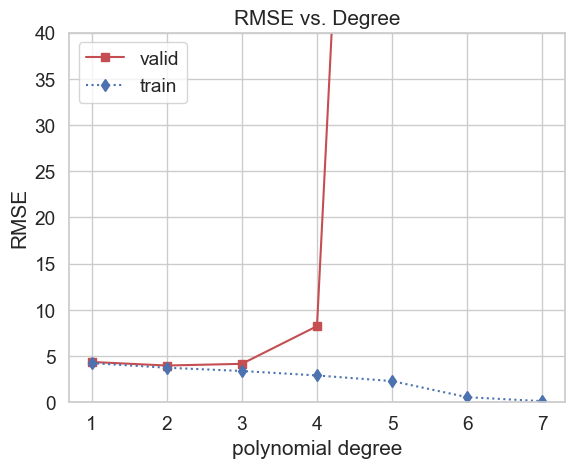

In [269]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

### Short Answer 1c

What degree is needed to bring the number of transformed features above the number of training data, $G > N$? Does training the model at that degree behave how we would expect, given the theory explored in class?

In [270]:
# WRITE ANSWER IN YOUR REPORT!

### Implementation 1D: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [271]:
best_idx    = int(np.argmin(fv_err_va_list))
best_degree = degree_list[best_idx]
best_pipe   = fv_pipeline_list[best_idx]

# predict
yhat_tr = best_pipe.predict(x_tr_MF)
yhat_va = best_pipe.predict(x_va_NF)
yhat_te = best_pipe.predict(x_te_PF)

# compute RMSE
err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr)
err_va = calc_root_mean_squared_error(y_va_N, yhat_va)
err_te = calc_root_mean_squared_error(y_te_P, yhat_te)

print("Selected Parameters:")
print(f"degree={best_degree}")
print("Fixed validation set estimate of heldout error:")
print(round(err_va, 4))
print("Error on the test-set:")
print(round(err_te, 4))

Selected Parameters:
degree=2
Fixed validation set estimate of heldout error:
3.9741
Error on the test-set:
3.9915


In [ ]:
model1_err_tr = err_tr
model1_err_va = err_va
model1_err_te = err_te

print("\nStored Errors:")
print(f"Train Error:      {model1_err_tr:.4f}")
print(f"Validation Error: {model1_err_va:.4f}")
print(f"Test Error:       {model1_err_te:.4f}")


Stored Errors:
Train Error:      3.1000
Validation Error: 4.1000
Test Error:       3.9915


### Implementation 1E

We'll now try to repeat the above *without* the MinMaxScalar preprocessing step. 

Part 1:

* Make a copy of make_pipeline__unpenalized_linear_regr_with_poly_feats, call it make_pipeline__bad
* Edit the function so it does not perform MinMaxScalar, but does everything else as before.

Part 2:

* Fit a pipeline without preprocessing at each degree value [1, 2, ... 7]
* Record the train error at each degree value




### Short Answer 1e

What happens to train error as a function of degree when the MinMaxScalar preprocessing step is omitted? Can we make sense of this trend using the concept of overfitting, or is there some other explanation? For a LR model with polynomial features and degree above 2, why is it useful to rescale each feature column to be in the interval 0 to 1?


In [273]:
# WRITE ANSWER IN YOUR REPORT!

# Problem 2: Alpha Selection on Fixed Val Set

In [274]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


### Implementation 2A

In [275]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:
    # pipeline: scaler -> Polynomial(deg=my_degree) -> Ridge(alpha)
    pipe = make_pipeline__ridge_linear_regr_with_poly_feats(
        degree=my_degree, alpha=alpha
    )
    pipe.fit(x_tr_MF, y_tr_M)

    # predict + sanitize to [0, Y_MAX]
    yhat_tr = sanitize(pipe.predict(x_tr_MF).ravel())
    yhat_va = sanitize(pipe.predict(x_va_NF).ravel())

    # RMSE (provided helper)
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr)
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va)

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)
    fv2_pipeline_list.append(pipe)

### Figure 2: Error vs alpha

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

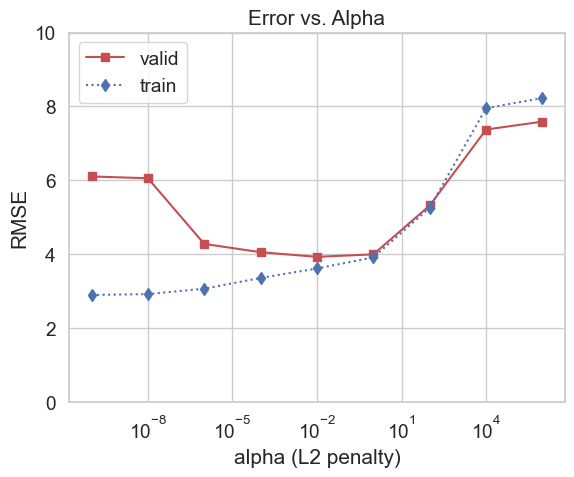

In [276]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [277]:
# pick best alpha from Problem 2A (min val RMSE)
best_idx2   = int(np.argmin(fv2_err_va_list))
best_alpha  = float(alpha_list[best_idx2])
best_pipe2  = fv2_pipeline_list[best_idx2]

# predict (sanitize to [0, Y_MAX])
yhat_tr = sanitize(best_pipe2.predict(x_tr_MF).ravel())
yhat_va = sanitize(best_pipe2.predict(x_va_NF).ravel())
yhat_te = sanitize(best_pipe2.predict(x_te_PF).ravel())

# errors
err_tr2 = calc_root_mean_squared_error(y_tr_M, yhat_tr)
err_va2 = calc_root_mean_squared_error(y_va_N, yhat_va)   # fixed-val estimate
err_te2 = calc_root_mean_squared_error(y_te_P, yhat_te)

print("Selected Parameters:")
print(f"degree={my_degree}, alpha={best_alpha:g}")
print("Fixed validation set estimate of heldout error:")
print(round(err_va2, 4))
print("Error on the test-set:")
print(round(err_te2, 4))

Selected Parameters:
degree=4, alpha=0.01
Fixed validation set estimate of heldout error:
3.9314
Error on the test-set:
3.8777


In [278]:
# Store for later use
model2_err_tr = err_tr2
model2_err_va = err_va2
model2_err_te = err_te2

print("\nStored Errors:")
print(f"Train Error:      {model2_err_tr:.4f}")
print(f"Validation Error: {model2_err_va:.4f}")
print(f"Test Error:       {model2_err_te:.4f}")


Stored Errors:
Train Error:      3.6160
Validation Error: 3.9314
Test Error:       3.8777


### Short Answer 2a in Report

Inspect the learned weight parameters of your chosen degree-4 model.

What do you notice about the relative magnitudes compared to the degree-4 model from Problem 1?

In [279]:
# WRITE ANSWER IN REPORT!

### Short Answer 2b

*See instructions on website*



# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total. We can use all 292 examples to develop models.

In [280]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter configuration (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [281]:
K = 10  # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list  = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))

# use all train+val data for CV
X_fv_MF = np.vstack([x_tr_MF, x_va_NF])
y_fv_M  = np.concatenate([y_tr_M, y_va_N])

cv_train_err_list = []
cv_valid_err_list = []

for param in ridge_param_list:
    # make pipeline
    pipe = make_pipeline__ridge_linear_regr_with_poly_feats(
        degree=param["degree"], alpha=param["alpha"]
    )

    # run K-fold CV
    tr_err_K, va_err_K = train_models_and_calc_scores_for_n_fold_cv(
        pipe,
        X_fv_MF,
        y_fv_M,
        n_folds=K,
        random_state=SEED  # reproducible
    )

    # average errors across folds
    err_tr = float(np.mean(tr_err_K))
    err_va = float(np.mean(va_err_K))

    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)

### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [282]:
# Find index of best model from CV (lowest validation error)
best_idx = int(np.argmin(cv_valid_err_list))
best_params = ridge_param_list[best_idx]

# Re-train pipeline with best (degree, alpha) on full dev set (train+val)
pipe_best = make_pipeline__ridge_linear_regr_with_poly_feats(
    degree=best_params["degree"], alpha=best_params["alpha"]
)
pipe_best.fit(X_fv_MF, y_fv_M)

# Predictions
yhat_tr = pipe_best.predict(x_tr_MF)
yhat_va = pipe_best.predict(x_va_NF)
yhat_te = pipe_best.predict(x_te_PF)

# Errors
model3_err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr)
model3_err_va = calc_root_mean_squared_error(y_va_N, yhat_va)
model3_err_te = calc_root_mean_squared_error(y_te_P, yhat_te)

In [283]:
print("Selected Parameters:")
print(best_params)
print("10-fold CV estimate of heldout error:")
print(cv_valid_err_list[best_idx])
print("Error on the test-set:")
print(model3_err_te)

Selected Parameters:
{'degree': 7, 'alpha': 0.1}
10-fold CV estimate of heldout error:
3.859947335404563
Error on the test-set:
3.8168267610804003


In [284]:
# Store for later reporting
model3_err_tr = float(model3_err_tr)
model3_err_va = float(model3_err_va)
model3_err_te = float(model3_err_te)

print("\nStored Errors:")
print(f"Train Error:      {model3_err_tr:.4f}")
print(f"Validation Error: {model3_err_va:.4f}")
print(f"Test Error:       {model3_err_te:.4f}")


Stored Errors:
Train Error:      3.6931
Validation Error: 3.7583
Test Error:       3.8168


## Table 3 : Comparing pipelines on test set

In [285]:
result_row_list = []

result_row_list.append(
    dict(
        name='predict mean of train ys',
        hypers='',
        testRMSE=baseline_err_te,
    ))

result_row_list.append(
    dict(
        name='LR deg=best-on-val',
        hypers=f"degree={best_degree}",    # from Problem 1D
        testRMSE=model1_err_te,
    ))

result_row_list.append(
    dict(
        name='ridgeLR deg=4 alph=best-on-val',
        hypers=f"degree={my_degree}, alpha={best_alpha}",   # from Problem 2B
        testRMSE=model2_err_te,
    ))

result_row_list.append(
    dict(
        name='ridgeLR deg=best-on-CV alph=best-on-CV',
        hypers=f"degree={best_params['degree']}, alpha={best_params['alpha']}",  # from Problem 3B
        testRMSE=model3_err_te,
    ))


In [286]:
pd.set_option('display.precision', 3)
result_df = pd.DataFrame(result_row_list)
result_df

,name,hypers,testRMSE
0,predict mean of train ys,,7.104
1,LR deg=best-on-val,degree=2,5.100
2,ridgeLR deg=4 alph=best-on-val,"degree=4, alpha=0.01",3.878
3,ridgeLR deg=best-on-CV alph=best-on-CV,"degree=7, alpha=0.1",3.817
